In [7]:
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt
import os

In [8]:
# Enumerate connected RealSense cameras
ctx = rs.context()
devices = ctx.query_devices()
device_serials = [device.get_info(rs.camera_info.serial_number) for device in devices]
device_serials.sort()

# Print selected device serial numbers
print("Selected device serial numbers:", device_serials)

# Create a pipeline for each camera
pipelines = []
align = rs.align(rs.stream.color)
base_dir = './images'

# Initialize RealSense pipeline for each camera
for idx, serial in enumerate(device_serials):
    os.makedirs(f'{base_dir}/calib/camera{idx+1}_rgb', exist_ok=True)
    os.makedirs(f'{base_dir}/calib/camera{idx+1}_depth', exist_ok=True)
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_device(serial)
    config.enable_stream(rs.stream.color, 1920, 1080, rs.format.rgb8, 30)
    config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    pipeline.start(config)
    pipelines.append(pipeline)

    # Save the intrinsics of the camera
    profile = pipeline.get_active_profile()
    color_profile = profile.get_stream(rs.stream.color)
    color_intrinsics = color_profile.as_video_stream_profile().get_intrinsics()
    print(f'Camera {idx+1} color intrinsics: {color_intrinsics}')
    # convert to numpy array
    color_intrinsics = np.array([[color_intrinsics.fx, 0, color_intrinsics.ppx],
                                 [0, color_intrinsics.fy, color_intrinsics.ppy],
                                 [0, 0, 1]])

    # save the distortion coefficients(set 0)
    color_distortion = np.array([0, 0, 0, 0, 0])
    print(f'Camera {idx+1} color distortion: {color_distortion}')

    # save the depth scale
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_scale = depth_sensor.get_depth_scale()
    print(f'Camera {idx+1} depth scale: {depth_scale}')

    # save all the parameters
    np.savez(f'{base_dir}/calib/camera{idx+1}_params.npz', color_intrinsics=color_intrinsics,
             color_distortion=color_distortion, depth_scale=depth_scale)

Selected device serial numbers: ['145422070656']
Camera 1 color intrinsics: [ 1920x1080  p[956.298 546.581]  f[1363.77 1361.57]  Inverse Brown Conrady [0 0 0 0 0] ]
Camera 1 color distortion: [0 0 0 0 0]
Camera 1 depth scale: 0.0010000000474974513


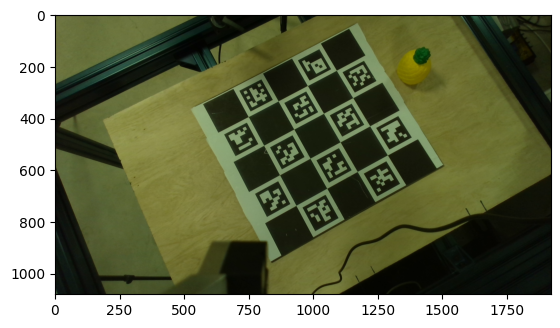

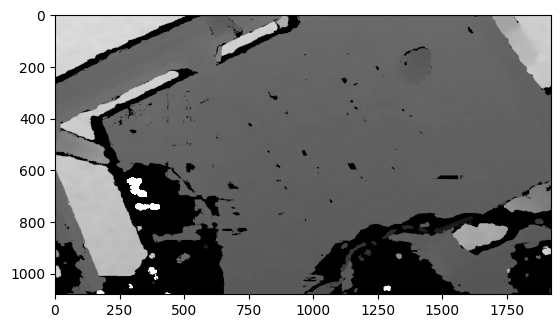

Saved ./images/calib/camera1_rgb/8.png
Saved ./images/calib/camera1_depth/8.npy


In [9]:
frame_num = 8
for idx, pipeline in enumerate(pipelines):
    # Wait for the next set of frames from the camera
    frames = pipeline.wait_for_frames()
    aligned_frames = align.process(frames)
    color_frame = aligned_frames.get_color_frame()
    depth_frame = aligned_frames.get_depth_frame()

    if not color_frame or not depth_frame:
        continue

    # Convert frames to numpy arrays
    color_image = np.asanyarray(color_frame.get_data())
    depth_image = np.asanyarray(depth_frame.get_data())

    # show the images
    plt.imshow(color_image)
    plt.show()
    plt.imshow(depth_image, cmap='gray', vmin=100, vmax=2000)
    plt.show()

    # Save the images
    rgb_filename = f'{base_dir}/calib/camera{idx+1}_rgb/{frame_num}.png'
    depth_filename = f'{base_dir}/calib/camera{idx+1}_depth/{frame_num}.npy'

    plt.imsave(rgb_filename, color_image)
    np.save(depth_filename, depth_image)
    
    print(f"Saved {rgb_filename}")
    print(f"Saved {depth_filename}")